<a href="https://colab.research.google.com/github/baotram153/Reinforcement-Learning/blob/main/notebooks/On_policy_Prediction_with_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem modeling

### State space
- Start state : 500
- Terminal states: 0, 1001 (value = 0)
- Other : 1 - 1000

### Action space
- Move left / right in range 100 $\rightarrow$ action space = [-100, 100]

### Rewards
- Leftmost (0) : -1
- Rightmost (1001) : +1

In [ ]:
! pip install pygame
! pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tqdm
from tqdm import tqdm

In [ ]:
N_STATES = 1000
START_STATE = 500
TERM_STATES = [0, N_STATES + 1]
LEFT_ACTIONS = np.arange(-100, 0)
RIGHT_ACTIONS = np.arange(1, 101)
ACTIONS = np.concatenate((LEFT_ACTIONS, RIGHT_ACTIONS), axis = 0)
N_ACTIONS = np.size(ACTIONS)
REWARDS = np.zeros(N_STATES+2)
REWARDS[0], REWARDS[N_STATES+1] = -1, 1

## Helpers
- Module to plot step function

In [ ]:
def plot_step_func(x, y, n_step): # x.shape / n_step = y.shape (1 dimension array)
    new_y = np.zeros(x.shape[0])
    for i in range (y.shape[0]):
        for j in range (i*n_step, i*n_step+n_step):
            new_y[j] = y[i]
    plt.plot(x, new_y)

# Dynamic Programming
- Dynamic Programming value function
$$v_{k+1}(s) = \sum_{a} \pi(a|s) \sum_{s', r'}  p(s',r'|a,s)(r' + \gamma v_k(s'))$$

In [ ]:
# use dynamic programming to calculate all states' true values
def dynamic_programming(gamma = 1):
    threshold = 10**(-1)
    old_vals = np.random.rand(1002)   # include terminal states
    new_vals = np.zeros(1002)
    while True:
        for i in range(1, N_STATES+1):
            new_vals[i] = 0
            for action in ACTIONS:
                new_state = i + action
                new_state = min(max(new_state, 0), 1001)
                if (new_state == 0):
                    new_vals[i] += 1 / (N_ACTIONS) * (-1 + gamma * old_vals[new_state])
                elif (new_state == 1001):
                    new_vals[i] += 1 / (N_ACTIONS) * (1 + gamma * old_vals[new_state])
                else:
                    new_vals[i] += 1 / (N_ACTIONS) * gamma * old_vals[new_state]
        err = np.sum(abs(old_vals - new_vals))
        if (err < threshold):
            break
        else:
            old_vals = np.copy(new_vals)
    return new_vals

# Feature Construction

## State Aggregation

In [ ]:
class StateAgregation:
    def __init__(self, n_groups, n_states = N_STATES):
        self.n_groups = n_groups
        self.n_states = n_states
        self.group_size = int((n_states - 1) / n_groups) + 1
        self.params = np.zeros(n_groups)
        # self.features = []
        # for i in range(n_groups):
        #     feature = np.zeros(n_groups)
        #     feature[i] = 1
        #     self.features.append(feature)

    def get_group_idx(self, state):
        group_idx = int((state-1) / self.group_size)
        group_idx = max(min(group_idx, self.n_groups-1), 0)  # prevent out of bound
        return group_idx

    def get_state_value(self, state):
        if (state == 0 or state == N_STATES+1):
            return 0
        group_idx = self.get_group_idx(state)
        return self.params[group_idx]

    def update_param(self, state, delta):
        group_idx = self.get_group_idx(state)
        self.params[group_idx] += delta

    def get_state_value_vector(self):
        state_values = []
        for state in range(N_STATES+2):
            state_values.append(self.get_state_value(state))
        return state_values

    def print_values(self):
        print(f"Group values: {self.params}")

## Polynomial Basis

In [ ]:
class PolynomialBasis:
    def __init__(self, order, states) -> None:  # include all state - idx from 0
        self.order = order
        self.features = []
        for state in states:
            feature = []
            for j in range(order+1):    # each feature vector has {order} dimension
                s = state / N_STATES    # normalize s to [0,1]
                feature.append(s**j)
            self.features.append(feature)
        self.params = np.zeros(order + 1)

    def reset(self):
        self.params = np.zeros(self.order + 1)

    def get_feature(self, state):
        return np.asarray(self.features[state])

    def get_state_value(self, state):
        if (state == 0 or state == N_STATES+1):
            return 0
        return np.dot(self.get_feature(state), self.params)

    def update_param(self, state, delta):
        grad = self.get_feature(state)
        self.params += delta*grad

    def get_state_value_vector(self):
        state_values = []
        for state in range(N_STATES+2):
            state_values.append(self.get_state_value(state))
        return state_values

    def print_values(self):
        print("First 10 state values: ")
        for i in range(1, 11):
            print(f"{self.get_state_value(i)}   ")
        print("Last 10 state values: ")
        for i in range(N_STATES - 10, N_STATES + 1):
            print(f"{self.get_state_value(i)}, ")


## Fourier Basis

In [ ]:
class FourierBasis:
    # k = 1 for random walk
    def __init__(self, order, states) -> None:  # include all state - idx from 0
        self.order = order
        self.features = []
        for state in states:
            feature = []
            for j in range(order+1):    # each feature vector has {order} dimension
                s = state / N_STATES    # normalize s to [0,1]
                feature.append(np.cos(np.pi*j*s))
            self.features.append(feature)
        self.params = np.zeros(order + 1)

    def reset(self):
        self.params = np.zeros(self.order + 1)

    def get_feature(self, state):
        return np.asarray(self.features[state])

    def get_state_value(self, state):
        if (state == 0 or state == N_STATES+1):
            return 0
        return np.dot(self.get_feature(state), self.params)

    def update_param(self, state, delta):
        grad = self.get_feature(state)
        self.params += delta*grad

    def get_state_value_vector(self):
        state_values = []
        for state in range(N_STATES+2):
            state_values.append(self.get_state_value(state))
        return state_values

    def print_values(self):
        print("First 10 state values: ")
        for i in range(1, 11):
            print(f"{self.get_state_value(i)}   ")
        print("Last 10 state values: ")
        for i in range(N_STATES - 10, N_STATES + 1):
            print(f"{self.get_state_value(i)}, ")

## Coarse Coding

## Tiling

In [ ]:
class Tiling:
    def __init__(self, tile_width, n_tilings, offset) -> None:
        self.tile_width = tile_width
        self.n_tilings = n_tilings
        self.offset = offset

        # number of tiles in a tiling needed for each state feature to have equal number of active components
        # self.n_tiles = int(N_STATES+2 / self.tile_width) + 1
        self.n_tiles = int(((n_tilings - 1)*offset + (N_STATES + 2)) / self.tile_width) + 1

        # number of params: n_tilings x n_tiles
        self.params = np.zeros((self.n_tilings, self.n_tiles))

        # save start of each tiling
        self.tiling_starts = np.arange(-self.tile_width + 1, 1, self.offset)

    def get_state_value(self, state):
        if (state in TERM_STATES):
            return 0
        state_value = 0
        for tiling_idx in range (self.n_tilings):
            tile_idx = int((state - self.tiling_starts[tiling_idx]) / self.tile_width)
            state_value += self.params[tiling_idx, tile_idx]
        return state_value

    def update_param(self, state, delta):   # just delta
        for tiling_idx in range (self.n_tilings):
            tile_idx = int((state - self.tiling_starts[tiling_idx]) / self.tile_width)
            self.params[tiling_idx, tile_idx] += delta

    def get_state_value_vector(self):
        state_values = []
        for state in range(N_STATES+2):
            state_values.append(self.get_state_value(state))
        return state_values

    def print_value(self):
        print("First 10 state values: ")
        for i in range(1, 11):
            print(f"{self.get_state_value(i)}   ")
        print("Last 10 state values: ")
        for i in range(N_STATES - 10, N_STATES + 1):
            print(f"{self.get_state_value(i)}, ")

# Algorithms

In [ ]:
def cal_VE(true_values, approx_values, distribution):    # distribution: 1 dimension array
    square_err = (true_values - approx_values)**2
    return np.dot(distribution, square_err)

## Gradient Monte Carlo

In [ ]:
def gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = False, true_values = []):
    state_values = np.zeros(N_STATES+2)
    y = []  # store VE
    state_count = np.zeros(N_STATES + 2)
    for i in range(n_eps):
        states = [START_STATE]
        rewards = []
        old_state = START_STATE
        while True:     # loop for each episode
            action = np.random.choice(ACTIONS)
            new_state = min(max(old_state + action,0), N_STATES+1)
            state_count[old_state] += 1
            new_reward = REWARDS[new_state]
            states.append(new_state)
            rewards.append(new_reward)
            if (new_state in TERM_STATES):
                states.pop()    # pop terminal state
                break
            old_state = new_state
        return_val = 0
        for j in reversed(range(np.asarray(states).shape[0])):
            update_state = states[j]
            reward = rewards[j]
            state_value1 = value_func.get_state_value(update_state)
            return_val = reward + gamma*return_val
            delta = alpha*(return_val - state_value1)
            value_func.update_param(update_state, delta)
        if (i % plt_step == 0):
            if (save_VE == True):
                state_values = value_func.get_state_value_vector()
                state_distribution = state_count / np.sum(state_count)
                y.append(cal_VE(true_values, state_values, state_distribution))
                # value_func.print_values()
                # print(f"Current VE = {y[-1]}")
            else:
                value_func.print_values()
    state_values = value_func.get_state_value_vector()
    state_distribution = state_count / np.sum(state_count)
    if (save_VE == True):
        return state_values, y, state_distribution
    else:
        return state_values, state_distribution

## Semi-gradient TD(0)

In [ ]:
def semi_gradient_TD_0(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = False, true_values = []):
    # MRP -> policy is choosing each action from action space uniformly
    state_values = np.zeros(N_STATES + 2)
    y = []  # store VE
    state_count = np.zeros(N_STATES+2)
    for i in range(n_eps):
        old_state = START_STATE
        while True:
            new_action = np.random.choice(ACTIONS)
            new_state = max(min(old_state + new_action, N_STATES+1), 0)
            state_count[old_state] += 1
            old_state_value = value_func.get_state_value(old_state)
            new_state_value = value_func.get_state_value(new_state)
            delta = alpha*(REWARDS[new_state] + gamma*new_state_value - old_state_value)
            value_func.update_param(old_state, delta)
            old_state = new_state
            if new_state in TERM_STATES:
                break
        if (i % plt_step == 0):
            if (save_VE == True):
                state_values = value_func.get_state_value_vector()
                state_distribution = state_count / np.sum(state_count)
                y.append(cal_VE(true_values, state_values, state_distribution))
                # value_func.print_values()
                # print(f"Current VE = {y[-1]}")
            else:
                value_func.print_values()
    state_values = value_func.get_state_value_vector()
    state_distribution = state_count / np.sum(state_count)
    if (save_VE == True):
        return state_values, y, state_distribution
    else:
        return state_values, state_distribution

# Experiment

## Calculate true state values via DP

In [ ]:
true_values = dynamic_programming()
print(f"DONE! True values: {true_values}")

DONE! True values: [ 0.         -0.92076039 -0.91949887 ...  0.92193674  0.92316052
  0.        ]


## Figure 9.1



In [ ]:
value_func = StateAgregation(10)
n_eps = 100000
print_step = 10000
alpha = 2*10**(-5)
state_values, state_distribution = gradient_Monte_Carlo(value_func, n_eps, print_step, alpha)

Group values: [-1.99982001e-04 -6.59788844e-04 -8.39655692e-04 -6.99762052e-04
 -5.59848826e-04 -5.99988000e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Group values: [-0.32514575 -0.44299552 -0.39482834 -0.26395921 -0.08878357  0.08202497
  0.24466557  0.35914755  0.40711702  0.31061937]
Group values: [-0.51590969 -0.57686089 -0.44963173 -0.26297166 -0.07383313  0.10882934
  0.30656016  0.47636     0.58609259  0.52022369]
Group values: [-0.64147567 -0.63792419 -0.4857132  -0.30342466 -0.10414384  0.0922938
  0.28949137  0.4799653   0.63234053  0.64183394]
Group values: [-0.7111795  -0.6431915  -0.46931829 -0.2829491  -0.08260115  0.09310691
  0.29449989  0.48241272  0.65426238  0.71274042]
Group values: [-0.75899596 -0.64348806 -0.46027855 -0.2770345  -0.09746073  0.08000828
  0.26281098  0.45212709  0.6495417   0.75691786]
Group values: [-0.79234861 -0.65427151 -0.47398113 -0.27677741 -0.09400205  0.07899255
  0.26573862  0.45882649  0.64308092  0.78158761]
G

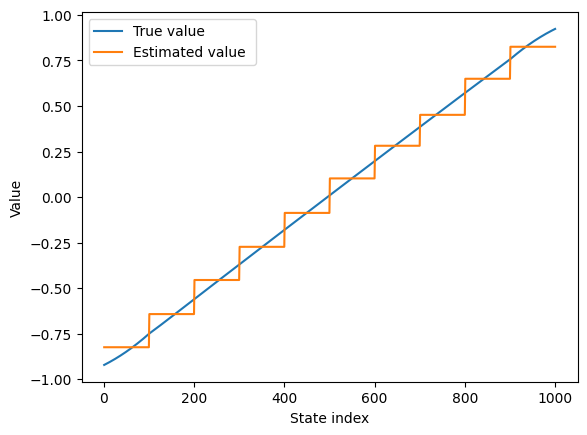

In [ ]:
# plot_step_func(np.arange(0,1000), group_values, 100)
x = np.arange(1, N_STATES + 1)
plt.plot(x, true_values[1:N_STATES+1])
plt.plot(x, state_values[1:N_STATES+1])
# plt.plot(x, true_values[1:N_STATES+1], x, state_values[1:N_STATES+1], x, 100*state_distribution[1:N_STATES+1])
plt.xlabel("State index")
plt.ylabel("Value")
plt.legend(["True value", "Estimated value "])
plt.show()

## Figure 9.2

In [ ]:
value_func = StateAgregation(10)
n_eps = 100000
plt_step = 10000
alpha = 2*10**(-4)  # 2*10**(-5)
state_values, state_distribution = semi_gradient_TD_0(value_func, n_eps, plt_step, alpha)

Group values: [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0002]
Group values: [-0.45835479 -0.23605039 -0.12168344 -0.0579398  -0.01318345  0.02306099
  0.06527226  0.12838796  0.2402477   0.46728597]
Group values: [-0.59836202 -0.38431055 -0.23776067 -0.1252666  -0.02581629  0.05658498
  0.1432666   0.25005686  0.39562473  0.60610641]
Group values: [-0.65749278 -0.44852444 -0.28778651 -0.15591338 -0.02961617  0.07530959
  0.18645207  0.31313693  0.46618055  0.66779714]
Group values: [-0.67751172 -0.4701344  -0.30615497 -0.15693034 -0.0240074   0.08903323
  0.21403725  0.3468541   0.5010958   0.69928253]
Group values: [-0.69333943 -0.488567   -0.31220265 -0.16008437 -0.02206076  0.09498163
  0.22095548  0.35839952  0.51819198  0.71650367]
Group values: [-0.69552022 -0.48484303 -0.31202223 -0.15975108 -0.01942771  0.10074125
  0.23015298  0.37077571  0.53181531  0.72068833]
Group values: [-0.69273088 -0.48343953 -0.31175332 -0.15510171 -0.01102748  0.10911563
  0.2

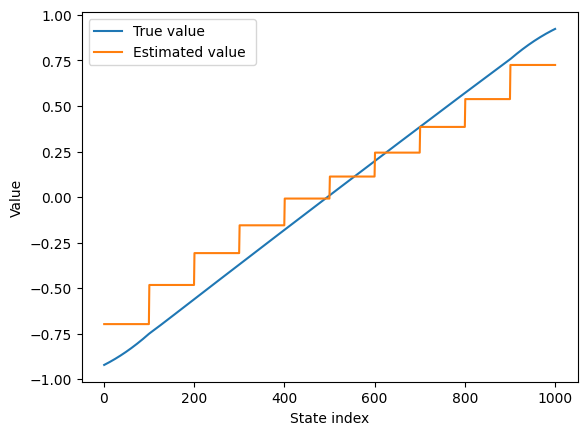

In [ ]:
x = np.arange(1, N_STATES+1)
plt.plot(x, true_values[1:N_STATES+1])
plt.plot(x, state_values[1 : N_STATES+1])
plt.xlabel("State index")
plt.ylabel("Value")
plt.legend(["True value", "Estimated value "])
plt.show()

## Figure 9.5

In [ ]:
def experiment (n_eps, n_runs, value_func, plt_step, alpha):
    ys = []
    for _ in tqdm(range(n_runs)):
        value_func.reset()
        state_values, y, state_distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)
        ys.append(y)
    return np.average(ys, axis = 0)

In [ ]:
n_eps = 5000
plt_step = 50
alpha = 0.00005
n_runs = 20

In [ ]:
value_func = FourierBasis(5, np.arange(N_STATES+2))
y1 = experiment(n_eps, n_runs, value_func, plt_step, alpha)
# state_values, y1, state_distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)


  5%|▌         | 1/20 [00:10<03:22, 10.67s/it]

[0.15297403019458644, 0.13232227060233467, 0.11568550578690216, 0.09947356763622978, 0.0870809843183578, 0.07948063429481134, 0.08857861959867858, 0.07758372371175605, 0.0596158039234858, 0.060279726725305224, 0.06730391740151836, 0.061236636240949945, 0.05212487107533411, 0.04053052596106037, 0.03291840085900896, 0.03929332623162606, 0.03176601836977534, 0.033131280036802865, 0.024205495057933096, 0.01931277844608044, 0.017181464665643433, 0.015458344962584025, 0.014853715923798015, 0.01412819964238299, 0.015578183597769874, 0.013230765974523804, 0.012708509861167125, 0.01792002481810778, 0.013787255345737031, 0.01088218217365925, 0.00982521581015601, 0.010659488977538026, 0.009944417023953654, 0.009426046059353667, 0.007735135335632571, 0.011777947426535021, 0.016838359126318984, 0.00820508956809085, 0.012629655106677769, 0.009234572767093188, 0.007217657526827775, 0.005457552169150247, 0.004231498849347717, 0.005340486560599229, 0.0037579011438632847, 0.007819589587179598, 0.0034552

 10%|█         | 2/20 [00:24<03:47, 12.67s/it]

[0.064361971556363, 0.13349216766229327, 0.11850551461515159, 0.10746252727528487, 0.10128585998190734, 0.09389571203235711, 0.0736469641989852, 0.06342743618189652, 0.05567512114516284, 0.05357322932807483, 0.04423879100746685, 0.04200140636589767, 0.036576083620616644, 0.033113020909131395, 0.030223027616720792, 0.027564818890962982, 0.024931056000652988, 0.02179088832399144, 0.023470470482488646, 0.02615690940574545, 0.020210679473343204, 0.018910967182223685, 0.01440633111415096, 0.014721045979060864, 0.013347618197133839, 0.012485619487975816, 0.014670528416720991, 0.015951432745055685, 0.011243445945170773, 0.00877345290537429, 0.007951487071509018, 0.008736071671127645, 0.009728895498561837, 0.008879338858539249, 0.007439962892361621, 0.010268976288535151, 0.008253558148390516, 0.007225070908001498, 0.008929533290019368, 0.015396375735142014, 0.005204871891373539, 0.005863312886617453, 0.005687787311892923, 0.005288903418644743, 0.011299481600060194, 0.006277497165121292, 0.0068

 15%|█▌        | 3/20 [00:34<03:10, 11.21s/it]

[0.11345354179943241, 0.1477979583067783, 0.1347527834223896, 0.11595487992609671, 0.09698235306602884, 0.09347929147337922, 0.08457642055056476, 0.07562554041943703, 0.07099412730707697, 0.06421900242419137, 0.054658911245573566, 0.05384686208980548, 0.04775612143436298, 0.041966790866297426, 0.038543856721439784, 0.03622298111692126, 0.03185019175084093, 0.028691883631204007, 0.025399826425117192, 0.023570151855372375, 0.022013484272171886, 0.022134763531455843, 0.019231242541548822, 0.016914915630733433, 0.01683341247876676, 0.016482499682425756, 0.013992448229180299, 0.01301399047061964, 0.0110859329860321, 0.009655427836223703, 0.010347236322161337, 0.011309215726531758, 0.011979360064944614, 0.011567540170266394, 0.009335245016352765, 0.008715724585701934, 0.008990210600295777, 0.007913467722140029, 0.006865756727297496, 0.00647399665161126, 0.006419077018957609, 0.005891550285693035, 0.0067625548440671205, 0.006444005067418585, 0.007976793709167852, 0.004626820171126875, 0.00444

 20%|██        | 4/20 [00:45<02:59, 11.19s/it]

[0.18113282173071787, 0.13719229672725436, 0.12119596356002431, 0.11336154370894164, 0.09476617219826247, 0.08857394528784669, 0.07554929861372592, 0.06743520904324862, 0.06055378939645519, 0.05437478907215837, 0.05365707716083945, 0.04843019981381046, 0.04301271028738591, 0.03704410317390428, 0.035669506870106865, 0.03359274993097928, 0.034694175042155655, 0.02506041681986856, 0.02596878151211327, 0.022075847734011365, 0.019922649605157366, 0.017536321311575488, 0.01727963540897044, 0.016214235264863312, 0.01680386657857304, 0.013892998027160916, 0.016451371275416737, 0.01751531958411737, 0.010560806058167034, 0.014159717751179664, 0.01294748209215659, 0.012702849573989126, 0.013637687114662768, 0.01617187540598527, 0.013102433774740803, 0.02322499827487381, 0.01801348060483769, 0.01150389811492484, 0.009157352649981328, 0.005864514698917265, 0.01468570822301619, 0.020757373485983166, 0.02169529159347302, 0.00831485479784995, 0.0038459248746961043, 0.0038453492703445467, 0.00607233090

 25%|██▌       | 5/20 [00:56<02:47, 11.15s/it]

[0.29310827845190157, 0.12712475654986324, 0.11267024952789348, 0.10191887788807594, 0.08792660464053433, 0.07945919201476492, 0.06507941072604494, 0.056033887231768734, 0.05566822365882186, 0.045194565182214715, 0.04996875540131897, 0.04476512832168117, 0.03366584159959493, 0.03207247211162525, 0.03414658401776758, 0.02592800160432345, 0.0276146367311199, 0.02611505041043666, 0.020589912380103652, 0.01911496676464345, 0.023704763830223227, 0.017925893449523143, 0.015956134145929824, 0.019629916201359156, 0.016965340778208417, 0.015244002392742909, 0.012426153829446868, 0.011568345369979647, 0.010684855947562341, 0.009629931810509333, 0.009266892144365444, 0.010224827516994408, 0.01001484138746032, 0.013251379998304426, 0.02947195474154352, 0.013675454293069336, 0.019518428532836606, 0.02054804779038804, 0.02165261182945081, 0.01104028131884705, 0.0061811065205467875, 0.005117022069948827, 0.004892007047860137, 0.0047239029114102314, 0.007674988623270151, 0.010367969209793602, 0.009214

 30%|███       | 6/20 [01:14<03:09, 13.52s/it]

[0.28126923891595396, 0.1462640792180573, 0.12602264231155874, 0.10877358413078334, 0.09087175646784211, 0.07565694795127867, 0.07067840235976725, 0.0585526140809347, 0.04996558357888325, 0.0469018185685519, 0.04366605499433104, 0.03920643094443463, 0.03673622241227445, 0.039393034203070096, 0.035590467971935005, 0.029117268971024374, 0.028242564591221708, 0.04041498876332998, 0.030186279122698494, 0.025039018147488976, 0.02282837066946785, 0.019157490496450134, 0.02230631613834374, 0.01577120597416541, 0.011925707435637735, 0.01268971900965296, 0.015784553577323952, 0.013981915339642175, 0.015900586147097998, 0.01071381335655241, 0.010108154096922776, 0.0094660101118833, 0.0070027857013297175, 0.0062087610305678305, 0.005594733413762806, 0.005844954518559596, 0.015297882473049433, 0.008262361153053531, 0.005630145905822539, 0.00896142152245892, 0.00905672086842856, 0.006621798092612746, 0.003935853407555419, 0.004192306118481973, 0.004587344599827962, 0.004532867302198178, 0.005375663

 35%|███▌      | 7/20 [01:25<02:46, 12.81s/it]

[0.1906271274859902, 0.15244337233644042, 0.13044626322014174, 0.1252740506425754, 0.1029840560222051, 0.08882879536010019, 0.07756317701119521, 0.06742627594630227, 0.056483196568061146, 0.054367882175359136, 0.055672301860254805, 0.04165583840503436, 0.03729730257731099, 0.03212501981948592, 0.028446991176611574, 0.039395200423655484, 0.03505934887973038, 0.025989315871400916, 0.02222172349821756, 0.019347943255806875, 0.018621130229851374, 0.018881097227224312, 0.02348125161226362, 0.02159849872028975, 0.02154686578745896, 0.021292875672864867, 0.012446611729660075, 0.015853855741476377, 0.013579593596711398, 0.012946358324853855, 0.010160850507084044, 0.010017400084400871, 0.011510658995710741, 0.00835058726876836, 0.010443371628270035, 0.013578957266116383, 0.01459026079917135, 0.011224016535004164, 0.011551062089192547, 0.01634396283029832, 0.011848255513394391, 0.01363203340430642, 0.008304848702112191, 0.008781559259641024, 0.009349125945077636, 0.006301738209636697, 0.00378040

 40%|████      | 8/20 [01:36<02:26, 12.24s/it]

[0.08365739924916285, 0.13677698775274172, 0.12394035708134038, 0.10437724026550706, 0.08937376619696867, 0.081542124075084, 0.06720171836647666, 0.05921904894543719, 0.060563878181634466, 0.059574241392458316, 0.048752064607940106, 0.04531576616468788, 0.04061457402722616, 0.044474219785328395, 0.027616827679359763, 0.0258039470594277, 0.023566286056513695, 0.022205367503308933, 0.02192806091185927, 0.018134311322875938, 0.0181443980410192, 0.014833235505823664, 0.01614957083538684, 0.014040754600891811, 0.013666426279910653, 0.01079621301741262, 0.010128325178820624, 0.019371840726958422, 0.01305272867279998, 0.014699898610515176, 0.011613094549858708, 0.016076498114812817, 0.025409353434054358, 0.015928867556314393, 0.020203419195124223, 0.021546488754141276, 0.016863725147874074, 0.012534961635227658, 0.009502707241497129, 0.018737438323401127, 0.010175218707480001, 0.006021177666418998, 0.0055652559686487565, 0.004442462622548124, 0.008233612115963632, 0.011914169304149748, 0.0055

 45%|████▌     | 9/20 [01:48<02:10, 11.90s/it]

[0.21670727155582953, 0.14696304322520337, 0.13041691245423595, 0.10626064438690107, 0.09174580633961836, 0.08376371175132993, 0.07439246766025927, 0.06690912805041366, 0.05812148785276082, 0.048667298251609856, 0.04731345680864101, 0.04376235826855305, 0.041259544998276734, 0.039903939326670385, 0.03301141084807027, 0.032059527830533965, 0.030502314562428513, 0.028984037879849812, 0.028231550137863645, 0.026541158398502022, 0.03723964007036976, 0.031202562398104837, 0.03196366479592392, 0.02878124018848756, 0.017498008983803316, 0.01277382094786752, 0.012653551514299673, 0.01577805561693782, 0.020881938717008365, 0.015750934147924146, 0.009554757289898944, 0.009980994759001693, 0.010501729764576981, 0.008337576271246167, 0.010327720072873005, 0.02496402329570759, 0.006500100456397995, 0.006676702822132553, 0.0070453929114037105, 0.005327949341280989, 0.004681249057624433, 0.0043081719184472934, 0.004448854641192247, 0.006734916175110766, 0.0103275689746991, 0.0038213279925486286, 0.00

 50%|█████     | 10/20 [01:58<01:53, 11.33s/it]

[0.24621526479223232, 0.14195552574214815, 0.11845687995777433, 0.10476496008311457, 0.08953280742916814, 0.08306051051962451, 0.07342388907842112, 0.07366514865290563, 0.0623303690017278, 0.05082902376023329, 0.04782913944938708, 0.04944683960901259, 0.043278636434764435, 0.03567642989815577, 0.03536002346107433, 0.031271316195217246, 0.03490272192925749, 0.031192723186577228, 0.024404105235529733, 0.019856121236149597, 0.017355340424786068, 0.018950744166554626, 0.0203361581655192, 0.01670337338285737, 0.015053335795589776, 0.03490009395905731, 0.024876764052562356, 0.027459786180166673, 0.029000186986328443, 0.010140010962481464, 0.0085672423162914, 0.01046098923900378, 0.012351674446331664, 0.008907452208537031, 0.009496869950470901, 0.010546681581999584, 0.01692752697087512, 0.007618295647494016, 0.007847030750590145, 0.008454134354439318, 0.011429063002723545, 0.010883368756943573, 0.006336509224146353, 0.004618597559223423, 0.00413113593127137, 0.003686691035946803, 0.0055736812

 55%|█████▌    | 11/20 [02:08<01:38, 10.96s/it]

[0.2978245204508401, 0.13663642660287117, 0.11450951129864127, 0.09841495869621861, 0.09109439416081351, 0.07949593305710206, 0.07182888930169995, 0.0631780368145373, 0.05408982754680091, 0.05227177854686518, 0.047621236898091474, 0.03993265296341433, 0.03605253099991889, 0.031658092636963654, 0.029511437132185542, 0.02569717321239776, 0.024410723092109277, 0.0230611224495011, 0.020777220701542906, 0.018549857623134745, 0.019177744090937174, 0.01977411757483246, 0.018237175330838035, 0.021357472503664578, 0.018762633495538403, 0.016900021419682887, 0.02086148826857295, 0.020924752872784114, 0.013552358770164164, 0.009093423223967815, 0.016065779866451132, 0.01725958538908524, 0.01642706705250546, 0.010523860722614346, 0.00818483437787073, 0.0067105824314694276, 0.013171490939455731, 0.013765419817894368, 0.005315232503915395, 0.0066482793499644, 0.004760761084728631, 0.0045968956047610175, 0.00966071293277341, 0.005883524401002719, 0.01011336427371335, 0.008706116195166475, 0.018080538

 60%|██████    | 12/20 [02:19<01:29, 11.14s/it]

[0.11965025819128185, 0.13330894506360783, 0.11519742255666819, 0.10302891759651443, 0.0855995153149686, 0.07751397771178885, 0.0658965020134232, 0.05894977874924441, 0.0620831759905488, 0.05255402552728849, 0.04787077919987779, 0.04360233355973555, 0.03954497452836082, 0.054561281763836615, 0.036536796604226526, 0.030472152093784594, 0.028837725360089005, 0.022335982806042463, 0.019616823236928364, 0.020550139887654563, 0.018652756197573225, 0.02033604640550966, 0.015656880746743936, 0.01645393410640215, 0.014209513592241856, 0.012968824283203896, 0.016894174595589628, 0.01685131176686327, 0.014932765362336972, 0.011695278131508766, 0.010166665284822707, 0.008551531319497081, 0.014826187053104973, 0.013252905269340493, 0.007243944161840216, 0.006566882422071648, 0.006640876654503064, 0.0077473960181642905, 0.0061494860906837895, 0.007147450590649604, 0.004287312926788543, 0.004412565895002727, 0.006460724736162854, 0.0067111077074565005, 0.00325338120906262, 0.002778702365490579, 0.00

 65%|██████▌   | 13/20 [02:30<01:17, 11.11s/it]

[0.12729097421960403, 0.13134615877769018, 0.11082236910757003, 0.0992800721841153, 0.0814441008358681, 0.07370692620729025, 0.06494763135045725, 0.05583704980297697, 0.0505609296901485, 0.044362684394269436, 0.03881387423490929, 0.03546370465446118, 0.031657908279043724, 0.02955480121390354, 0.025803453413505862, 0.02444831323232456, 0.03466870418642723, 0.026673874594779132, 0.027945844270884354, 0.0188103798266955, 0.016789227919044983, 0.01595786675988992, 0.014536592390783231, 0.015807645573909023, 0.015138442449131762, 0.014435237202363749, 0.02376394004377349, 0.01364644805496359, 0.011195649654377415, 0.00954085797532961, 0.009805571322071315, 0.00887030417478024, 0.010952603894127765, 0.013283293153535835, 0.013249105186251203, 0.011783681966790631, 0.015912778458966693, 0.011912755177194524, 0.01109125239884001, 0.007605292619483556, 0.009380111809499266, 0.023852922552685635, 0.026252793820195432, 0.041597796366094605, 0.029261070473442945, 0.0152644162485115, 0.004549745731

 70%|███████   | 14/20 [02:43<01:08, 11.44s/it]

[0.11918758660107123, 0.12758622095293878, 0.12004709441521141, 0.10591094374864106, 0.10805864135243515, 0.08300181174760723, 0.07411967685880046, 0.06944819627891281, 0.06050491960826961, 0.0555097616071754, 0.0477385331875187, 0.04233235202191591, 0.04665845957135238, 0.04524690196220152, 0.03914747796083325, 0.037349189607949584, 0.034394841072293944, 0.035943733207712804, 0.025735958350616553, 0.029954851761674554, 0.0326066774751543, 0.021925199248674945, 0.026041291330494574, 0.015253774968070516, 0.018011956625018474, 0.017866643806003068, 0.012424529327680121, 0.012140485210440099, 0.011534960766496396, 0.018638131557506276, 0.012721311857361835, 0.012292980794056147, 0.012353154644394413, 0.01544282460220115, 0.006482492878827511, 0.007145371889248238, 0.008938857076079481, 0.007870107647398846, 0.010418491392539551, 0.008200560306791671, 0.005102434312890921, 0.007308097859305603, 0.00802373294461175, 0.006511299903310415, 0.00652529572523635, 0.0063983099664222136, 0.009621

 75%|███████▌  | 15/20 [02:54<00:57, 11.50s/it]

[0.12870770701227124, 0.12412797133264415, 0.11473892926784479, 0.099555240994757, 0.08900839491756482, 0.07987693989640947, 0.06615025713876407, 0.058592985439552145, 0.05192205275546767, 0.051239861286481905, 0.045631594784621504, 0.04220864131608091, 0.04774438977175002, 0.04603470910475459, 0.04425730318605808, 0.036572614685144667, 0.02845667042472076, 0.02574922594596645, 0.023117532033302326, 0.024224246123729004, 0.02209684563348397, 0.019294169239843367, 0.0195272554940741, 0.017713564577932873, 0.0177291541388687, 0.01640427029329058, 0.01618994271105582, 0.01411090724002172, 0.012302208754353125, 0.011894746476197945, 0.009933948174084436, 0.011078184244521946, 0.010430989378039471, 0.011476456261719045, 0.013959812773154024, 0.009295785681724815, 0.009909466013320347, 0.006800678547314827, 0.007669380000730203, 0.006174932561814443, 0.0065050245363371334, 0.006966255213851277, 0.0053420786481284096, 0.004947124596698722, 0.006592715430042922, 0.010309364734715325, 0.0061013

 80%|████████  | 16/20 [03:05<00:44, 11.20s/it]

[0.1289919655395349, 0.14399311822386066, 0.1267068929046689, 0.11861483011324783, 0.10374284580895632, 0.08731554093236209, 0.07611101573044578, 0.06666356078061622, 0.057712992969100305, 0.06267417800791131, 0.04744902602721379, 0.04181524037891203, 0.037868844590469485, 0.031718721381871165, 0.029285564138279943, 0.02452114715731171, 0.02276593258361982, 0.021721882280575627, 0.019728207932960453, 0.018246153679408145, 0.018287062532651166, 0.019483464949165592, 0.026273479184671943, 0.01672938673706965, 0.014529497901444725, 0.01618197668065727, 0.016935079839407098, 0.011468481286790165, 0.011266945512182358, 0.009395975924736552, 0.008908703667734115, 0.00904605294964629, 0.007969837191119468, 0.007571037065788817, 0.00855657730986822, 0.006603266301472764, 0.006983059337880026, 0.006383666649868836, 0.006649194669679627, 0.00598420100001998, 0.0049130416722370255, 0.007513517258015045, 0.007796764388239569, 0.021422268611484455, 0.01995960480568345, 0.014860344862045414, 0.00684

 85%|████████▌ | 17/20 [03:15<00:32, 10.99s/it]

[0.22495416558875833, 0.13468752177693044, 0.12104263676857455, 0.10974324098613288, 0.09000263005395542, 0.0855879711156761, 0.07653116194595495, 0.08126921538841421, 0.07187901236278083, 0.05947213160578837, 0.0506979585630138, 0.04431208372299072, 0.04449079359631697, 0.036782658144437846, 0.03463645080263335, 0.031035917423568083, 0.029236114674012728, 0.023536763207957646, 0.022066844849267235, 0.01952366512113439, 0.018666103433785927, 0.015727757165397406, 0.014591646764114688, 0.013386292207817955, 0.01594847316217473, 0.015469460028033441, 0.020319782169696845, 0.02588421690020785, 0.015268842493405368, 0.013315804532951092, 0.011925870886445719, 0.022297788834285945, 0.015973090842200784, 0.008725055557628954, 0.015134644620748197, 0.014322434334006288, 0.021572615446786684, 0.0057004621545621815, 0.005224186018546575, 0.006336089309522067, 0.00795266491215969, 0.017054943920333725, 0.010109658177790588, 0.009797071141531147, 0.004319399356424393, 0.0040401460734542744, 0.010

 90%|█████████ | 18/20 [03:26<00:22, 11.02s/it]

[0.09107164096741205, 0.1557074246729154, 0.12613112877279314, 0.1096615799615127, 0.10151069424813074, 0.08764872500498971, 0.0723664753758501, 0.06974830888338654, 0.07892190728646643, 0.05578089550065273, 0.04519457593462263, 0.043800504332318795, 0.0491096262850032, 0.0348849365335604, 0.029919909222204572, 0.02813054866269467, 0.02418913138946951, 0.02158601412279084, 0.02114416594256305, 0.019750238512158867, 0.016190591131072185, 0.01458729720153058, 0.015312384567830836, 0.014333783515954905, 0.012471256562928554, 0.01085263549218544, 0.01647184256106299, 0.02259490413036508, 0.013395238292225232, 0.019302581139350714, 0.021785907437276736, 0.04087822908424928, 0.022470976481461097, 0.020787177931276095, 0.011923105877603852, 0.00641442217099271, 0.018434826697760025, 0.009374149161833803, 0.005786123235344242, 0.004093743624996472, 0.003506880116827053, 0.004912099747459146, 0.003753645718460114, 0.005342860725508023, 0.003015098501261918, 0.003837351544845742, 0.0100206848125

 95%|█████████▌| 19/20 [03:38<00:11, 11.09s/it]

[0.19539321505752416, 0.14588770868155662, 0.10886440711662546, 0.09242213519912941, 0.07766635867956875, 0.07416979335714186, 0.06446049626786232, 0.060198701180539466, 0.05182488182975203, 0.047845912323717654, 0.05358038685311955, 0.05202602791812165, 0.037655260825968956, 0.03921786969854417, 0.03442975849289217, 0.03289130325044749, 0.028171244081164993, 0.024528928128919974, 0.02367118653618758, 0.022747423429990955, 0.021297218546730404, 0.02109455227460251, 0.016534466033759364, 0.015448168676363465, 0.015002789691881442, 0.015926611894246535, 0.017537487993231918, 0.018358313159116773, 0.01842709000171824, 0.017688334518410617, 0.01940337857679494, 0.02200457867252316, 0.018066257639196948, 0.012266681472905626, 0.01021469966043796, 0.008398809703601358, 0.008619125651159529, 0.0065108262174191096, 0.0064449123827526695, 0.006109943454037291, 0.005418247136364992, 0.006601116697884805, 0.004683718606265854, 0.005002201724556315, 0.004750106335126079, 0.004491232249916934, 0.00

100%|██████████| 20/20 [03:49<00:00, 11.46s/it]

[0.07755428504309422, 0.1434162558336799, 0.13102993584069025, 0.10771965560531142, 0.09131509590268197, 0.0780998727772747, 0.066068644812136, 0.05828647402959142, 0.0576888568856042, 0.057075201433999065, 0.04838461830300101, 0.05205370129698634, 0.044076442637636666, 0.03582997284616122, 0.033363267573082514, 0.03759591870376794, 0.033805042604877426, 0.029880020713906785, 0.029071563159416634, 0.02132150933430567, 0.019966455782715945, 0.018306873050742755, 0.01646214488832693, 0.016645779526870044, 0.015764508580711382, 0.01521132110092861, 0.015172314080986234, 0.013218879220400825, 0.012856234309194161, 0.013415569507463306, 0.014814820922495295, 0.010238068368756575, 0.016313926725433598, 0.010424618095568607, 0.008933628076309735, 0.011077385097350045, 0.013761691401608472, 0.010496484054888329, 0.007058249580975519, 0.00658083904064895, 0.006554559485249953, 0.005834996838899035, 0.0059125315013368865, 0.006333288422771285, 0.014928049268477003, 0.02123361978809587, 0.0102377

In [ ]:
value_func = FourierBasis(10, np.arange(N_STATES+2))
y2 = experiment(n_eps, n_runs, value_func, plt_step, alpha)
# state_values, y2, state_distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)


  5%|▌         | 1/20 [00:10<03:20, 10.54s/it]

[0.1885366923826761, 0.13514933170038332, 0.12407416732058107, 0.10108694728779867, 0.08897265192483726, 0.08251418264841459, 0.07017679963406731, 0.05869499701983305, 0.05262585935021252, 0.04302203677454242, 0.037937707791514896, 0.034459528515967126, 0.033257166524780175, 0.028977221609750765, 0.025489755054337766, 0.024458717894135236, 0.021845244741644686, 0.019218047750270997, 0.017235786187311832, 0.019886189608590694, 0.016615265115651194, 0.015492698945698718, 0.016521388561787566, 0.012396673097061994, 0.011736280217354369, 0.011482807398335218, 0.010750487559820417, 0.013034975012438901, 0.010133977595944194, 0.012619868724276485, 0.00878830102278513, 0.008183370669170461, 0.007195648939041212, 0.007875911492134593, 0.006869527677149579, 0.01155632942615274, 0.01532722372259378, 0.014518527329699629, 0.006677499708985452, 0.007536518540509494, 0.006135289373408058, 0.005195891597743311, 0.006814973811246312, 0.003672337220522595, 0.004608568765860517, 0.0031340561196980367, 

 10%|█         | 2/20 [00:21<03:15, 10.88s/it]

[0.22501296245108976, 0.15085038272380338, 0.13156295016527922, 0.12337343599510074, 0.10211246227197184, 0.08400342145608826, 0.0694566547606996, 0.06064150740120805, 0.055709212545357364, 0.048338794601034525, 0.04472658583645909, 0.03709956306685429, 0.033947416599099806, 0.03610587300600611, 0.026897967142447635, 0.02796147935921124, 0.02820740586626027, 0.020965158535927376, 0.023538806358478957, 0.019594187475970363, 0.017911281012525326, 0.017259131978205902, 0.01473327535510297, 0.013289623757399668, 0.012956760897292084, 0.01275795620029024, 0.011236953156359876, 0.013762975505355893, 0.016411167706160416, 0.01084434894591632, 0.016813345368129517, 0.010505805531509376, 0.010912749985694678, 0.01004438940059117, 0.012994646490913909, 0.008705231295017823, 0.008129172960378147, 0.006213720982882393, 0.006966957527705381, 0.008832376213260579, 0.007839495411981218, 0.006915119803351403, 0.006410332151810464, 0.008930021139034319, 0.021488916023686026, 0.008996499899747904, 0.007

 15%|█▌        | 3/20 [00:33<03:12, 11.30s/it]

[0.26456124935789965, 0.14286256144574153, 0.1261529974537697, 0.10862233840625411, 0.10565410690054262, 0.0950470982567365, 0.08992627730076758, 0.08016599680962587, 0.054356749493807116, 0.04951109986193626, 0.03963684356978142, 0.03656891694060643, 0.03548109059988499, 0.03110664212955247, 0.03181843085643429, 0.029285053138197008, 0.02882938747641117, 0.027650013061391105, 0.02007831054550721, 0.017948131188606605, 0.017342438251755493, 0.021287119289134997, 0.02613328742612607, 0.02075395731868316, 0.02556162033377996, 0.012492123368995812, 0.012797072000515938, 0.012507182354663334, 0.010119705417103178, 0.00923377503571672, 0.013623456594596583, 0.014003762997492782, 0.011948523042754816, 0.008081325741300384, 0.02446626224873111, 0.02971994288100956, 0.016573395814861835, 0.016865802764796035, 0.01839312397845262, 0.005229911490684712, 0.005147795512107524, 0.011450858440245062, 0.005768803584338803, 0.0052323075775518625, 0.00805205383587235, 0.00462095258152405, 0.01043935821

 20%|██        | 4/20 [00:45<03:03, 11.48s/it]

[0.12699026318319023, 0.12821073553707985, 0.1293987889820086, 0.11168039152603317, 0.10024037030258039, 0.08418021651852105, 0.07665331916639515, 0.06945729081465823, 0.0620522332525972, 0.06209409906115248, 0.04608831594379593, 0.03748363829202939, 0.06222566575628765, 0.0672386582425582, 0.04025791588056714, 0.0354309079575392, 0.04238596236985816, 0.025291174219954082, 0.02074498676705885, 0.016951645888824796, 0.015450796312541398, 0.016683204572441792, 0.01392259295347194, 0.01713473546402824, 0.012724950852191741, 0.010909002437899051, 0.009588187951712164, 0.011293314964431493, 0.009704584387995426, 0.007957220247957465, 0.007257630555266884, 0.008858194431819318, 0.014275239349655867, 0.01367029094892721, 0.011295799416404682, 0.014981861174249555, 0.010637905552751107, 0.00575448766383627, 0.005533737362915379, 0.005005936645930431, 0.004439150255190367, 0.004224983459209593, 0.005525641156273566, 0.004542583288704998, 0.006990670245688629, 0.009939078106790188, 0.01539633562

 25%|██▌       | 5/20 [00:57<02:56, 11.75s/it]

[0.18459029813633848, 0.13808150223205565, 0.12787204733942611, 0.10772904668306468, 0.09687431206756394, 0.07779435596085074, 0.0714672603681949, 0.06461185011482747, 0.05890736959750693, 0.052650432326698714, 0.04678050286587586, 0.04116897239921703, 0.03928101943913572, 0.03769743818543595, 0.03328448886493916, 0.02881348795112006, 0.027162337156912495, 0.02612776745644137, 0.023708996577126783, 0.02266751315549327, 0.019534391736887674, 0.018303973778752272, 0.01644892448685473, 0.01476406939002676, 0.013763766330832473, 0.013041335251111702, 0.012026560444683518, 0.012303221547197029, 0.01249621044722002, 0.01534227641257938, 0.011628850930449689, 0.008629811455495549, 0.008661710316181539, 0.009125293281280252, 0.008248118910360128, 0.006345977939996687, 0.01168356443895275, 0.007627754447319342, 0.0072119154706102055, 0.008516711594608095, 0.005407178542637597, 0.0047715854360337075, 0.004523332029895085, 0.0039003953773970304, 0.003521485637207662, 0.012630552277381177, 0.00670

 30%|███       | 6/20 [01:09<02:44, 11.77s/it]

[0.09705591632031273, 0.1295638736935106, 0.12447082879613287, 0.09976451925428663, 0.09193060985945732, 0.08365012581419078, 0.06899141590119287, 0.06351050155714384, 0.05431337048292826, 0.04783932590449908, 0.044501843920457036, 0.039474290568033116, 0.03520696340737923, 0.03167579086832877, 0.034590915060711346, 0.03352937298240666, 0.032751931644711164, 0.023170002123377213, 0.019572382856930883, 0.019718865941470255, 0.029028804193356034, 0.018451083528337804, 0.014932597237352957, 0.013506727654492302, 0.01565812165762291, 0.02322002594216369, 0.018364734999249125, 0.009911208073349805, 0.019842757218166147, 0.01986780874771146, 0.008094586657702449, 0.010340206125806843, 0.007366396532781399, 0.008546276633392332, 0.005627248744637574, 0.005300615982000334, 0.005231238210874998, 0.008595986444025143, 0.005437989833687317, 0.004183945707302506, 0.004382991449514716, 0.0064929729990460565, 0.004692039264885031, 0.005252467401470827, 0.0037151390802806885, 0.00893963004307535, 0.0

 35%|███▌      | 7/20 [01:21<02:33, 11.83s/it]

[0.26767576856054176, 0.14236970829902224, 0.11765230896597115, 0.10643234865853901, 0.09270176127228832, 0.08672818556828113, 0.08193589427518379, 0.08196748678703131, 0.07498403808462965, 0.07889431332309621, 0.05452677776255145, 0.049804548218242865, 0.041600591281418214, 0.033960084878716046, 0.031207148771887978, 0.029095076543728286, 0.025648574862437983, 0.023240728759637244, 0.021238137634971396, 0.019247065837742335, 0.018977420799649796, 0.017659612574259253, 0.0230098959330408, 0.017307174580987305, 0.017137335840506637, 0.016558206067373182, 0.021864024624046432, 0.020374123939301846, 0.028022537211999935, 0.013094312019220084, 0.011580318128987677, 0.011878721439410881, 0.01188896435722327, 0.008561709186566461, 0.008035716684327933, 0.00889025371310703, 0.007070133909018048, 0.01129343212950521, 0.02119305823427854, 0.016146224134654986, 0.012404252998602759, 0.011433800898826157, 0.01268614755025976, 0.011119824479105332, 0.007572368878452718, 0.004957007773087197, 0.007

 40%|████      | 8/20 [01:33<02:24, 12.01s/it]

[0.3214686081375884, 0.1352061801250001, 0.12468699223964916, 0.10300156928236782, 0.09063885894792623, 0.07837121839845469, 0.07211259413063031, 0.06381825048064516, 0.054486682457262965, 0.05332843493447992, 0.04945155390454448, 0.04281687543142739, 0.035599343045870195, 0.03315910678294814, 0.02906894128975436, 0.026568039151750697, 0.023860552076661677, 0.021039634081957855, 0.019446588769851513, 0.0189168947823496, 0.01844970018482401, 0.027172301955764987, 0.02081762082786159, 0.014493564687886781, 0.014582585906047761, 0.018485875609401077, 0.02810142433933963, 0.02150333837320253, 0.024047932288860117, 0.017956554380617613, 0.029331202084865164, 0.05515095094113642, 0.02777521012068692, 0.016859578330031065, 0.013555671493493945, 0.009985726221541261, 0.0078035001676660595, 0.005786323677076483, 0.005659380131133908, 0.006361346745498847, 0.010732312054372016, 0.007085774701602489, 0.010631258921847306, 0.008912583791929518, 0.005111742828575773, 0.009460305467002238, 0.0142457

 45%|████▌     | 9/20 [01:44<02:08, 11.71s/it]

[0.18345945498139438, 0.14432975378785304, 0.12900535223204776, 0.1086931474906615, 0.09541488754169888, 0.08331046051529134, 0.08289156339414397, 0.07114114604557656, 0.06245237135533065, 0.05382692019855529, 0.05023442172909781, 0.03712359280082751, 0.032947858678684334, 0.031394221420127086, 0.02994847881401674, 0.026746693319838723, 0.02500646536682679, 0.0263600813485867, 0.02776326459932858, 0.019581680005485783, 0.02131086175565556, 0.016445181397679635, 0.016277923804724863, 0.014005519849633349, 0.012688170422642355, 0.012800556856226336, 0.01817813540565657, 0.01690359823955911, 0.012857168912170376, 0.01418216978827883, 0.013277746030022691, 0.014770373593670767, 0.012519083966030877, 0.01041168462854578, 0.011552334880619594, 0.00655520295356589, 0.007183057785168991, 0.007474756836884779, 0.006836566682267085, 0.00866085878909969, 0.005470697075778624, 0.007268329907226981, 0.011593006600689015, 0.008125986136110699, 0.00786895410793514, 0.00824560994345408, 0.007128960919

 50%|█████     | 10/20 [01:56<01:57, 11.73s/it]

[0.10161042764722793, 0.15820853241275507, 0.13881405239203928, 0.11678998689048528, 0.09811747420296134, 0.07991000004199403, 0.06983291492251584, 0.06824617642141587, 0.06068718093596389, 0.05244365263456849, 0.050953190282096106, 0.04189564848109936, 0.03712909803650272, 0.034602498256783625, 0.034191182631618564, 0.03225346023732669, 0.02717060581774756, 0.02933843922001641, 0.026430373205766855, 0.026713488281553448, 0.017049526558007125, 0.01561033533044623, 0.015253998703149786, 0.01816446422275798, 0.01805350490256427, 0.016816890991463808, 0.013866048656159001, 0.010854946344565523, 0.010407559500593943, 0.00908422594907318, 0.009855297223792275, 0.00961854715809508, 0.010381542349644316, 0.00813852566996983, 0.012509648724296456, 0.005844552136813246, 0.0068453918423527615, 0.00535076118262434, 0.007272648093058296, 0.005674081646887951, 0.005546972108846232, 0.006139383666721773, 0.007946570724635565, 0.008204338666553722, 0.008419531674495228, 0.0036953784887659956, 0.00354

 55%|█████▌    | 11/20 [02:08<01:46, 11.83s/it]

[0.14299653894299036, 0.14421894919247344, 0.12304163178521904, 0.10959484877413109, 0.09559039667128276, 0.07378661471078725, 0.06825951429711816, 0.058214093559174694, 0.05123387635881646, 0.046790732045486484, 0.05354321971972112, 0.03834817425964111, 0.03541466564104858, 0.033267369863713966, 0.031945047119489874, 0.025419836453812017, 0.02563260838986205, 0.025229492875943754, 0.022219200973427663, 0.029688485249492417, 0.032055673588073874, 0.019995378279858367, 0.01800403210614327, 0.017198690703991423, 0.01393349356350728, 0.019556432333912244, 0.0139011981280862, 0.01665626914393475, 0.011872081794424059, 0.013516492259852188, 0.012693584605260542, 0.008454883341489671, 0.008181773703035852, 0.007485837694261328, 0.0070098528341811595, 0.006253683597965564, 0.014223579451754348, 0.017113291253628708, 0.041013721512669646, 0.02743297478039019, 0.03912631566485053, 0.023533168063826906, 0.01828560368642603, 0.02217842912290078, 0.003968801792516119, 0.012741191773007584, 0.02054

 60%|██████    | 12/20 [02:20<01:35, 11.96s/it]

[0.15240354828575103, 0.1532282453330379, 0.1292541673000873, 0.11061361105061726, 0.10039603514371159, 0.08211944985134556, 0.07298100123177127, 0.06166058334125808, 0.05809210544049236, 0.05574204650059313, 0.04484809756704178, 0.041343840527624916, 0.03635499090064362, 0.03294002464355309, 0.0445543671501385, 0.03805569337321821, 0.027017110843012834, 0.02322045593610951, 0.02235556434835901, 0.021588806276466203, 0.020303390506905748, 0.020122939504138463, 0.023040564034989035, 0.029362306372559002, 0.024224027084468823, 0.02363177445822932, 0.02882407293514382, 0.02699109638925193, 0.014843500359444291, 0.010670203151257723, 0.013423098319273387, 0.030700374272906564, 0.03366252765620533, 0.0197100258632752, 0.013422946441963008, 0.009691841335441067, 0.00735101042590519, 0.006631136592458705, 0.006018149452988915, 0.005419767674627583, 0.005366138068608378, 0.005698761413041373, 0.021981786068668713, 0.015069113177638599, 0.006705506508658866, 0.007966419004740127, 0.010506338159

 65%|██████▌   | 13/20 [02:33<01:24, 12.11s/it]

[0.14047623034369044, 0.1241753854610819, 0.11302905712379711, 0.1021132262026308, 0.09103532616713152, 0.08381225889165084, 0.071321400007051, 0.06279827766926484, 0.05265167181730216, 0.048111026372924984, 0.04397613497165819, 0.04554945738944505, 0.03569192657126808, 0.031451880500133665, 0.02973070949057218, 0.02734488541427156, 0.03424986803964365, 0.033368871298235694, 0.02963545230408699, 0.0277155590967753, 0.02951088352918468, 0.02280573244606277, 0.01893347810474185, 0.020737040031231717, 0.024374157737446462, 0.016981878954614425, 0.011455559926753376, 0.0141622840753348, 0.009963746912741678, 0.010136330316155108, 0.008485121957431743, 0.007074454834342017, 0.00714367809559597, 0.009707521012900237, 0.01109583588732625, 0.014534100369786416, 0.021530377849695637, 0.00974913571479858, 0.005169987387442353, 0.0060455984212245475, 0.008699691419110629, 0.012982284543790136, 0.00600532902035324, 0.005260713028393992, 0.005154826251239928, 0.004243364298497654, 0.005042167078925

 70%|███████   | 14/20 [02:45<01:13, 12.25s/it]

[0.1886159250460297, 0.14943168141870553, 0.12554502409033733, 0.1204594280246885, 0.1123518156331101, 0.08184132442166137, 0.0726665999809205, 0.06154473144664751, 0.05622590408641296, 0.05219601071400758, 0.04512971726396953, 0.044668067881708594, 0.03774159223835806, 0.038296242800802086, 0.031187182710145315, 0.03709988470620307, 0.03394672303510244, 0.039792648889381506, 0.03672715202059992, 0.03351514014901107, 0.02499298309122603, 0.020264597441734335, 0.01849841552766514, 0.018246136689008766, 0.013295330886692047, 0.023235662309668902, 0.012750049088001732, 0.01119044899854269, 0.010510926277450936, 0.01456209996382506, 0.014603870986095143, 0.013464798187983087, 0.011683665720690305, 0.012290936349889715, 0.010488095396281958, 0.007280594038690998, 0.006821736247581155, 0.005254319649284036, 0.006570773574275643, 0.004577330608960919, 0.00448137006366, 0.005114694732946304, 0.004460832700300325, 0.0035682072925608227, 0.004991776793217147, 0.007964632423961943, 0.009500608908

 75%|███████▌  | 15/20 [02:57<01:01, 12.21s/it]

[0.3229684135964571, 0.136660629496712, 0.11615307585084005, 0.09585419799126552, 0.08139077696659568, 0.0718681226828841, 0.0625686662453583, 0.058692170828502796, 0.05164547252884491, 0.05011281540132632, 0.0459982556637506, 0.041969622279230054, 0.03604607416270362, 0.03487804533501853, 0.03144441078164883, 0.026292716521230615, 0.026471618262807813, 0.026483140526129993, 0.031541566476564725, 0.020863594109282808, 0.017622047514437536, 0.017231085426933506, 0.014810456154046378, 0.013937476255581975, 0.014696599615604928, 0.014529325829027877, 0.013143459119611038, 0.01838243779327164, 0.011482760446240976, 0.009785920056799785, 0.013200306563111467, 0.009091177888145447, 0.008248460067676737, 0.009072177818734059, 0.011674340324700192, 0.0093629671832641, 0.00812377429066156, 0.007938470927427237, 0.019386145576575066, 0.013152001222126015, 0.008171203947409597, 0.010171508257180325, 0.011449313221908976, 0.015847772568017646, 0.006877204035077182, 0.005125395625652878, 0.00464554

 80%|████████  | 16/20 [03:09<00:48, 12.13s/it]

[0.14183690075953626, 0.15122959395556992, 0.1355553374943676, 0.1124935304084282, 0.1008499466472942, 0.08704093600687385, 0.07714157274254924, 0.06762185410814704, 0.05939573033489854, 0.05127937967475482, 0.04699844879334419, 0.04375064708761532, 0.03948844954222565, 0.035429806510214185, 0.03184808180476452, 0.031217138825683076, 0.028362479608891107, 0.027676526333236275, 0.02836547396049428, 0.02715904085345395, 0.02777254721458379, 0.02448893106847743, 0.02156103078532958, 0.016356639064774338, 0.01432631400607681, 0.013465774397295285, 0.011854751661203892, 0.015174971964246185, 0.014830023719896253, 0.012403506741756252, 0.009755953727125602, 0.017425995809055666, 0.01849340248773491, 0.019149658804943077, 0.023646223887598187, 0.010978669244836098, 0.012342789668412223, 0.007342957045583112, 0.007123410660483197, 0.009949389182418538, 0.004734549580131152, 0.004458336050805997, 0.00509472537751758, 0.004948938218592586, 0.004864686512961715, 0.0039140171622683035, 0.003390412

 85%|████████▌ | 17/20 [03:21<00:36, 12.10s/it]

[0.17707552096319668, 0.1401499234114973, 0.12962891400259216, 0.1087188077390645, 0.09217290800787306, 0.0821701603819836, 0.07021575088729107, 0.06796442383658209, 0.059425177779754035, 0.05137815726604001, 0.04900754051480776, 0.044797386705105025, 0.04019803920821847, 0.035452674513654234, 0.03488491110287748, 0.02947867990034388, 0.02434540519050827, 0.0230189980318954, 0.02081230170188809, 0.01916359903750223, 0.01996181936062395, 0.01830119255291881, 0.015818001779517265, 0.016688059477834676, 0.01611625127806579, 0.013145538078751356, 0.013440117428251505, 0.01114428812456128, 0.010767169678222688, 0.010404387716117151, 0.011515083746825769, 0.014495503597885982, 0.014224200318985657, 0.014706301545625562, 0.016716679105829094, 0.007956728994794835, 0.006323796234382216, 0.005648427034861314, 0.005086185818496165, 0.006869263210339978, 0.005933962883578013, 0.009163155251769153, 0.005328264171060361, 0.004055065781369266, 0.008770427553787987, 0.006024585326562318, 0.0066802075

 90%|█████████ | 18/20 [03:32<00:23, 11.75s/it]

[0.16214084355435568, 0.1442811965937011, 0.11927436573646594, 0.10708002194643405, 0.09253323638837602, 0.08288144618440037, 0.07838411119934713, 0.07412978254084338, 0.0702064665179569, 0.05517653280549064, 0.056515660859937165, 0.07493197356543213, 0.06477372161667837, 0.04142818875042056, 0.04423514571840332, 0.0484364241040258, 0.029452083648756625, 0.02661366813849289, 0.021215290304963913, 0.020333792656679724, 0.019513919276570795, 0.018781995383303777, 0.016896649438025872, 0.016113242176646093, 0.013130904108438134, 0.01248266311813136, 0.011802808433718882, 0.010637615602997665, 0.010748027098283867, 0.01119263117447268, 0.010162817888839668, 0.009592897471166139, 0.008423798567877795, 0.007275992620368566, 0.006711190713807875, 0.015447252119129496, 0.007284827712171587, 0.008323319798411766, 0.008267463850808583, 0.0048573856300081495, 0.004867413288640967, 0.004601210147408095, 0.004048867988908045, 0.005472692087861622, 0.006509734379159016, 0.00698583947647525, 0.012428

 95%|█████████▌| 19/20 [03:44<00:11, 11.76s/it]

[0.16209885111576172, 0.14562267314740837, 0.1271997934552173, 0.10869590517028585, 0.09299170640797705, 0.08191547116371047, 0.07332770137261721, 0.06797948549309944, 0.06178845677550216, 0.06661768669073999, 0.06951626326727206, 0.05350739565354581, 0.040450943045185844, 0.035949571402108485, 0.03528442321597409, 0.037707631703667484, 0.025571454507091834, 0.027851807336687535, 0.023926826638070157, 0.021552500098705043, 0.021338561009911546, 0.020554134336853637, 0.018139952206520628, 0.017499002977965514, 0.030525369449119474, 0.01576330241958069, 0.013487428379410254, 0.013504508530659784, 0.014588068768975348, 0.011303164156343186, 0.010880576539675517, 0.009800432621016946, 0.009616898497209142, 0.008621218090338048, 0.00783852028784415, 0.008870099275054751, 0.00873649662002114, 0.008586181725356919, 0.006897533104281034, 0.006910830604362713, 0.005556475788671411, 0.006184461039083106, 0.0049676194273260916, 0.012816043382673427, 0.009362937100800894, 0.004244639696843327, 0.0

100%|██████████| 20/20 [03:56<00:00, 11.83s/it]

[0.09607948563768526, 0.1472198963250867, 0.13166745154817014, 0.11417402821660302, 0.09711947213925633, 0.08504578652537506, 0.06867327587291056, 0.06955155057029436, 0.055625925355453035, 0.04813912291915687, 0.045259081877537057, 0.036131988251756696, 0.032192637137562596, 0.034453501610865814, 0.03648634345185343, 0.035200365828762036, 0.027173651608061834, 0.0259306442718811, 0.022554983397471723, 0.022162181627910366, 0.01886712386263059, 0.01602534874518528, 0.0138157539100836, 0.013506889634429416, 0.01210753133289178, 0.012221966683685973, 0.009986458369310752, 0.009465792373660523, 0.00942255240964166, 0.00996373612077576, 0.012203802506576406, 0.010781913626910233, 0.007557817768707313, 0.00916097372388938, 0.007564493125080338, 0.007143802731065379, 0.006682219407603855, 0.009664364041134682, 0.013069059541359507, 0.009463497343900302, 0.00826589496710561, 0.005111988947733135, 0.006226341064788599, 0.0046790798672751875, 0.004962405926155819, 0.0041948995496201786, 0.00686

In [ ]:
value_func = FourierBasis(20, np.arange(N_STATES+2))
y3 = experiment(n_eps, n_runs, value_func, plt_step, alpha)
# state_values, y3, state_distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)


  5%|▌         | 1/20 [00:12<03:57, 12.50s/it]

[0.160071655493542, 0.147235894965308, 0.12629075289434, 0.11654891327817933, 0.11385367833418847, 0.10284852957869907, 0.08141668990023512, 0.06782684726538632, 0.0605670423399473, 0.05104871793007253, 0.04955730989704586, 0.040605086912678466, 0.0451496146188247, 0.043945743227460525, 0.04631668394301867, 0.05347017763008307, 0.03446406644066473, 0.026185223729429746, 0.01997521358105291, 0.017117993310009086, 0.02067342776509581, 0.016829193493512067, 0.01677360563013217, 0.01931127353335194, 0.01271708664384904, 0.014741006236296199, 0.015096580531833116, 0.014438572788071261, 0.014522595446375916, 0.016092637054093546, 0.008448556390808553, 0.009771097813105664, 0.00734042063711292, 0.0075847016947157495, 0.006773335066220674, 0.006018467060448326, 0.007530083622562623, 0.01619467497949428, 0.007793439910405319, 0.00919213335891655, 0.01644236272823691, 0.010577696221846762, 0.015174638054398823, 0.019791315524112157, 0.010756696633272864, 0.005533883532132358, 0.00466757255974737

 10%|█         | 2/20 [00:25<03:48, 12.67s/it]

[0.08736712560820983, 0.125348976756696, 0.11556326351298529, 0.09995402061015185, 0.08981028498645065, 0.07475933459112398, 0.06456753359068895, 0.05776191593757653, 0.052241604330541896, 0.04575920448471349, 0.04301875498011208, 0.038917997410699026, 0.03677870134638654, 0.029045520904077953, 0.026945843630863445, 0.02627251370889368, 0.0207938842845426, 0.019189347790037836, 0.017764258655542205, 0.01734674270182164, 0.016267582856605164, 0.015335133212489707, 0.013605598710901957, 0.01276778589549335, 0.011233185318953573, 0.015008556616191968, 0.019856998434230583, 0.016592067965501698, 0.013455842761520226, 0.008545726787561091, 0.008788866280616542, 0.011839425530331984, 0.010324568485610216, 0.010350270227296761, 0.014891063839061679, 0.006627638042887899, 0.008484386671863848, 0.00522920458807808, 0.005503224329424141, 0.008613884152467345, 0.00725954860381092, 0.010424763422782651, 0.022497671136894153, 0.017171826363958923, 0.006934561812381996, 0.004818310384252005, 0.00628

 15%|█▌        | 3/20 [00:37<03:32, 12.51s/it]

[0.15931539124794558, 0.126379965305041, 0.11609035408457226, 0.0970339909691056, 0.09595388856782575, 0.08714181205194221, 0.07203374289749093, 0.06264422186771222, 0.052011654862993535, 0.044546893063004724, 0.04774659080725075, 0.046025194797715614, 0.03981026511147295, 0.03233639234185777, 0.030199996825338776, 0.029304917360272954, 0.026317938941653334, 0.022137041310939087, 0.022210416329023742, 0.022301641736280624, 0.020760284675469202, 0.016927926312394582, 0.014639984651359737, 0.01344564694833653, 0.012936102106995914, 0.01575939450108551, 0.015504205800125645, 0.015200013840970325, 0.010074449687217324, 0.011193087372878678, 0.016136571711992297, 0.018224686089395207, 0.01988100666702962, 0.011379989893767033, 0.013596267106090973, 0.012051948850607869, 0.009133783760320454, 0.00770363981327852, 0.006564404602381642, 0.007875523111583094, 0.013253774274641323, 0.012688995468102563, 0.005502735931064496, 0.008123061632755838, 0.006898313067488123, 0.006015274052432916, 0.005

 20%|██        | 4/20 [00:50<03:23, 12.70s/it]

[0.30144596039548244, 0.15554752039996864, 0.12414009364979273, 0.10809432329179491, 0.09404844389644344, 0.08036729596180252, 0.06969157199403872, 0.06468661747081152, 0.061327320819162055, 0.05597690361983687, 0.048978405987471815, 0.043314678990084364, 0.040699510403736136, 0.03259516872715903, 0.03187288020361712, 0.02674860175268285, 0.02263701886365626, 0.022428471305980018, 0.021020802441465238, 0.02221197257958114, 0.025295532250201883, 0.02024335360499367, 0.016269747128300777, 0.015255544154952254, 0.018472124188979963, 0.013728261743574837, 0.01073392718809034, 0.009753908864101784, 0.010323875912378861, 0.011245316913041948, 0.012039892752398754, 0.008721517075620695, 0.012709720650503247, 0.009730430591354667, 0.016966119161051466, 0.01731009710797955, 0.022350288243256664, 0.008725113748209248, 0.009209118603692357, 0.005700619279339609, 0.012776676949977096, 0.009556564655551318, 0.011180653466684239, 0.010804705602473066, 0.010482884566609804, 0.011383765463330277, 0.01

 25%|██▌       | 5/20 [01:02<03:07, 12.51s/it]

[0.17898165909228486, 0.14629301157618277, 0.12480620830141699, 0.10775958046214403, 0.09642705888804973, 0.08427953973260659, 0.07855233361402408, 0.06855724497841376, 0.05595093049661178, 0.05195125015846853, 0.053077604370811965, 0.04644509825721353, 0.041865727353617536, 0.039892396642968744, 0.03776937724375114, 0.03172905565146993, 0.04802082847384295, 0.02878205339192159, 0.027770184964516217, 0.028318880177546808, 0.023045116004499606, 0.017682005494276426, 0.020478999181811203, 0.02677818880392489, 0.029269559929199256, 0.04086728237567183, 0.024647765528784102, 0.02270433151894584, 0.026829135907527488, 0.028759917972112338, 0.02369522082485653, 0.0203642267666257, 0.007203000407026012, 0.006624730988092757, 0.008278063377100893, 0.006278489686553249, 0.006616762414561055, 0.00799269584545014, 0.005117086848572345, 0.00445316828729107, 0.004804279754427249, 0.004024139693050284, 0.00393444523492499, 0.004681784178588787, 0.0037477603042598232, 0.0036908742350244363, 0.0057973

 30%|███       | 6/20 [01:15<02:55, 12.56s/it]

[0.17572087497870673, 0.1539217442333492, 0.12426805705489476, 0.10343095551770265, 0.08591046651143193, 0.07286084725412723, 0.07154831051416047, 0.07176627676742153, 0.06095054053928973, 0.05014056365090534, 0.046149204739686756, 0.040965523619936474, 0.03742332441657284, 0.03568853171372173, 0.034042943062519024, 0.040714405291026, 0.037224742100681836, 0.035147778158121604, 0.026639259612707907, 0.025911946847610324, 0.01697890089284892, 0.021849730670337155, 0.026717838395131973, 0.028261612381322992, 0.027351642618337058, 0.013780790619517957, 0.015124965680118447, 0.012867748806466774, 0.010948112777198496, 0.009637448448721405, 0.009167364674646404, 0.008951780484384091, 0.01224663823205176, 0.019580777339060034, 0.03203230717729002, 0.018219289647651248, 0.01319335431964378, 0.019540134910922907, 0.011064174479189318, 0.01583261299504379, 0.009664446468161001, 0.0054555789879891245, 0.004714095383241964, 0.005197416920723675, 0.0057695536967535205, 0.003983910153906814, 0.0036

 35%|███▌      | 7/20 [01:28<02:43, 12.59s/it]

[0.31295077389195947, 0.1577767206587354, 0.1290808245966498, 0.10639442060470232, 0.09499502137802898, 0.08482680027556726, 0.07612231872320233, 0.07786671279869682, 0.06135236252398549, 0.06028894770993247, 0.06152915177873169, 0.053573074058275966, 0.04003593586731545, 0.038496945042506614, 0.038336453147881346, 0.03205458937834202, 0.02893211201136778, 0.02557703201263671, 0.025005997376623904, 0.022423047710028853, 0.0221549987237175, 0.019240347605679307, 0.021970648695054888, 0.01768780141840709, 0.016338295433645518, 0.01714119442317987, 0.014632135615615095, 0.013032490609720233, 0.01113909813934077, 0.01603491005116829, 0.009569919839025042, 0.009794491154981318, 0.009129209734025675, 0.009457458173763348, 0.008341330886327937, 0.009920394783905774, 0.019553764741767805, 0.0073040819416058805, 0.009527565575780514, 0.010240484781370697, 0.010993837700759491, 0.011389051148565204, 0.007843044082121452, 0.036694286751931426, 0.030021225346882466, 0.017439361237237692, 0.0095294

 40%|████      | 8/20 [01:41<02:35, 12.98s/it]

[0.16882532738475872, 0.1554279185001688, 0.14033627697118778, 0.11213062241509812, 0.09620906112991466, 0.07908230895066447, 0.06960924062759229, 0.07697859988635745, 0.07016321594617826, 0.061937137319494844, 0.05363950340741146, 0.039772799821792645, 0.036235708062168824, 0.03235987870082, 0.030215069326721876, 0.030298722203445563, 0.032914974958272544, 0.0306808532858338, 0.030285365488226263, 0.022356711028114536, 0.018406033682585136, 0.017801621955672954, 0.01566327865025707, 0.014280388171578687, 0.016110714812305332, 0.017122297029385516, 0.022558245035512264, 0.01803905689746088, 0.014710410473178228, 0.009035785556023673, 0.011274247472630398, 0.013204017869878867, 0.009557583745118146, 0.008560621821383398, 0.0066595122546956815, 0.006337081316290622, 0.009394783042578809, 0.016427657694194638, 0.013306675084685657, 0.013527012376974701, 0.006533264727560113, 0.005631081606752799, 0.004714984905936243, 0.005021000699628632, 0.005417560007999985, 0.006584787239513554, 0.005

 45%|████▌     | 9/20 [01:54<02:22, 12.97s/it]

[0.16517896662737025, 0.14687184987812407, 0.1414093552278912, 0.1294079023228589, 0.10630561077356006, 0.08621327167166781, 0.07509579304995868, 0.07169382270347659, 0.06575487760963575, 0.06767802357459138, 0.052303937750109185, 0.04852728690692462, 0.05024480487562523, 0.04361208265000829, 0.03674118296944168, 0.035369742663002426, 0.03048374465831263, 0.04373308295863499, 0.049784783911976854, 0.03741803528177684, 0.0311157564103419, 0.03193438847329313, 0.027508375366196918, 0.026345218789812386, 0.027610366467000123, 0.032359479864419095, 0.01744195901001772, 0.01360650940658943, 0.014594924878730035, 0.011312316093365086, 0.014985906797223402, 0.009524799969959826, 0.013262549012107437, 0.007609860214689355, 0.00778922441148343, 0.006548929017503606, 0.006449969320767234, 0.010035668303089482, 0.007531634288331703, 0.01084844602940282, 0.006760216927117957, 0.010468618351816589, 0.006331185043882586, 0.008364497212175734, 0.007377938427584744, 0.004231877623763872, 0.00682273507

 50%|█████     | 10/20 [02:07<02:09, 12.91s/it]

[0.15053934935799632, 0.13317358229639983, 0.11137377748267621, 0.0959637126087669, 0.08013764586175436, 0.08536494618010636, 0.07552355332265792, 0.06714814086705989, 0.06572789644934408, 0.06238636134912402, 0.04384299023934267, 0.04570490307902321, 0.03527397690968932, 0.036999190853151794, 0.03086892906862075, 0.02658523249828278, 0.028287782471421233, 0.024534587957317198, 0.025364895685891398, 0.02286247550185099, 0.019931241476120094, 0.018244169099755604, 0.015621842568955751, 0.01509211181148933, 0.017747065388353567, 0.016260941294943116, 0.02062162935827012, 0.01805497682546889, 0.014153266590741214, 0.014481595844267132, 0.011459565583158585, 0.01010556812713172, 0.009952257982471666, 0.00883755327277463, 0.009975128155604243, 0.015432724972006127, 0.011283938684268843, 0.007185680724020412, 0.005627615290585904, 0.0054914643925695035, 0.004979459909036938, 0.007384204439610331, 0.005388971816604069, 0.00594418699477762, 0.0041444286237142264, 0.004061774307211222, 0.004405

 55%|█████▌    | 11/20 [02:20<01:56, 12.92s/it]

[0.1728213360595689, 0.15085130213115713, 0.12502717013702946, 0.105528019357595, 0.08324703836871485, 0.07389230811266216, 0.07781075184520791, 0.08559139764411043, 0.0851589592393981, 0.07950025970971863, 0.06365974653992461, 0.058884456770880486, 0.04489662732495901, 0.04078972194935824, 0.03596897587056115, 0.03258616308124389, 0.03239439287398167, 0.028379446573756455, 0.027374395549551303, 0.027928144145372993, 0.024479354582085236, 0.018282798660800657, 0.018990047922979477, 0.017892120146124766, 0.0214328710659745, 0.028078934864791905, 0.02118522111177806, 0.01297616004647362, 0.014572997469980541, 0.01630845355994536, 0.022939979678029847, 0.02121613337224978, 0.016771647240672413, 0.015305036494759321, 0.00986410600032177, 0.018321234941434655, 0.016050022239499473, 0.00964017489391576, 0.017615448541777143, 0.00781612080092735, 0.005920548181194248, 0.012923038617942972, 0.01416971943952865, 0.005200946814375703, 0.003875330406467923, 0.0033207175358211153, 0.00335829070141

 60%|██████    | 12/20 [02:33<01:42, 12.81s/it]

[0.06327027229280408, 0.13544039811688519, 0.11529349117820348, 0.098260587940645, 0.08992316636029588, 0.0775666830208539, 0.06745922818566454, 0.06254695014787474, 0.05304469041757637, 0.04940704413536359, 0.0410719765580949, 0.037068240271976687, 0.03729632545841837, 0.03581150885034796, 0.03003760178534527, 0.026562916920232882, 0.024335937687916167, 0.02034192632620211, 0.019072233554488307, 0.017175794485726998, 0.015027234631749264, 0.014491579632923446, 0.014283372316676465, 0.02399558304954562, 0.014460457139188624, 0.014866577910980939, 0.02031491798088879, 0.02064498457984686, 0.02460710559187848, 0.023789196560486406, 0.028327974395823956, 0.018184024288241226, 0.013053213428285, 0.008993455872445487, 0.0078114706958467344, 0.006289828398578597, 0.0064749817510114036, 0.006137779045293682, 0.005103629938521947, 0.005555675751655931, 0.005905933352879431, 0.007267975311129315, 0.004266950888903505, 0.004121255964013196, 0.003579809404529306, 0.00562656981653135, 0.0037543691

 65%|██████▌   | 13/20 [02:45<01:29, 12.79s/it]

[0.1676065726881471, 0.14035502943931844, 0.12516497096478266, 0.10935892017556742, 0.09159694835787212, 0.08346340642023478, 0.07255736950248882, 0.06243261954147863, 0.05573674849115343, 0.047406913505576284, 0.03995393561642322, 0.03678475590139513, 0.03421908957529274, 0.031083121254601474, 0.03311842856294406, 0.026724198963233657, 0.025182750696367315, 0.023021544439603154, 0.03175353873817668, 0.03445492457268486, 0.023020504730874962, 0.01631379817195972, 0.01720906669025088, 0.013582870758391164, 0.016161418256091284, 0.015372848426742311, 0.032344063236054495, 0.051883291997852174, 0.04152692887219738, 0.03925119837151676, 0.015743989200323827, 0.009707275842762216, 0.008836825948717047, 0.007512223966964655, 0.010218406732409245, 0.0065244392515633656, 0.006967143949652085, 0.006208120540709738, 0.007783865651075929, 0.005645914033493575, 0.005494479648168298, 0.008710254639349716, 0.007054881594134986, 0.00808413639659669, 0.014921782917231726, 0.010333387964744662, 0.00808

 70%|███████   | 14/20 [02:58<01:16, 12.77s/it]

[0.07146427709635934, 0.137374168136018, 0.12907448316346298, 0.1169501963521691, 0.09114916485921316, 0.07476538400408995, 0.06708050620901698, 0.05839832123865315, 0.053178003404786595, 0.04708023044051502, 0.04313533020456035, 0.04382110803249996, 0.04376984911247078, 0.04078392475257976, 0.03914568414563387, 0.03530947536867894, 0.03607119836275399, 0.030322132228938935, 0.03568751268057561, 0.02585077113834681, 0.0248586159530986, 0.028471239638537482, 0.026944160043886837, 0.0167279292936144, 0.021718633161126707, 0.021101412512036597, 0.012281348276083837, 0.010407438058907757, 0.009462289672621717, 0.010204339022718823, 0.008796328396890938, 0.008437596144804162, 0.011631371105277953, 0.01357189143906955, 0.007366638228489333, 0.008136399008609714, 0.007050406683780113, 0.016120020478723126, 0.006498042817135148, 0.007459433442036849, 0.004935396540041188, 0.005116784697062055, 0.010628227916519553, 0.004249573548131553, 0.0037903023536324265, 0.003912709479901124, 0.0056488091

 75%|███████▌  | 15/20 [03:11<01:04, 12.82s/it]

[0.11497510223983745, 0.1356023793216466, 0.11490257685408087, 0.10176020580160457, 0.08799169769114543, 0.07786262790244557, 0.07079354341525824, 0.06006388316200194, 0.054461726980579855, 0.046731546537260485, 0.048560087078459525, 0.05010887661490007, 0.0391724318056687, 0.040100926615942285, 0.03808104132452338, 0.04669269034788781, 0.04667111185963702, 0.03214855282229934, 0.020769367857475067, 0.021850901224587896, 0.0172898224798739, 0.018628145695563963, 0.019529242736359677, 0.018757264878868484, 0.02018763650841054, 0.014229006320800739, 0.012710216925141514, 0.014195496505082707, 0.010271197444218465, 0.009759617182250501, 0.008899302532403132, 0.010495695362635995, 0.01120323359696091, 0.01375459523348267, 0.006366590854804206, 0.006174185346554898, 0.005903084297757679, 0.0058804952041619386, 0.005919446389378145, 0.005836275935053679, 0.009901827276654538, 0.004247530577914248, 0.004208775591709357, 0.0037113451954753655, 0.015434566554914583, 0.008277575634961497, 0.0050

 80%|████████  | 16/20 [03:24<00:51, 12.80s/it]

[0.22279201864868164, 0.14182279407377066, 0.12281932667089265, 0.10806330766731857, 0.09874400887674685, 0.09044333958591157, 0.08166389063800185, 0.0728114130178487, 0.06111372410958941, 0.052198115296497496, 0.04626500721833079, 0.039945927115714513, 0.034266647236086974, 0.032289659181341634, 0.030905891537034304, 0.02903357109343119, 0.02710340724330403, 0.02721849152145925, 0.023478478318207163, 0.019477937914884898, 0.02250812820978459, 0.019467896914477936, 0.01656841410917311, 0.014439876163502471, 0.01676970375511656, 0.018310555306966576, 0.024432531497170056, 0.03251787149774976, 0.01329697976263407, 0.011825250246831015, 0.0124471369879313, 0.01071604912425514, 0.010615003280544922, 0.009624226483914651, 0.00778437192247651, 0.00778350625097356, 0.007121361711934526, 0.007326195345996259, 0.005654127389791203, 0.0054294751680632036, 0.00690690195861218, 0.00583396770798026, 0.008302034555396872, 0.015595340085576163, 0.008683841752083957, 0.01073240582382079, 0.01491362402

 85%|████████▌ | 17/20 [03:37<00:38, 12.86s/it]

[0.108077879707959, 0.1491720383718638, 0.12161157029261603, 0.10292332752223327, 0.09189982197794905, 0.09184254237645331, 0.07744104391202973, 0.06941722323990306, 0.057815464192890784, 0.05001430633734448, 0.04555582136657041, 0.03838742331327583, 0.03749490745116412, 0.04009771060937006, 0.03610259856539609, 0.03154019303205707, 0.02531363624611284, 0.025192195644091177, 0.02376054354430297, 0.024200874621037465, 0.022567737056045246, 0.026102996973789722, 0.03456711283380623, 0.018821371063107772, 0.014921184485028839, 0.01925170833239261, 0.02049366510643132, 0.011963865818155202, 0.01590409074673699, 0.009448979630738638, 0.008473384114744568, 0.008471323298456554, 0.008240155846721442, 0.00782958965089065, 0.00981734599708678, 0.006637621515030682, 0.00742566394265323, 0.010572095894535056, 0.008970882807506561, 0.00598843890486064, 0.005238095035101736, 0.004970632779112799, 0.004882604991707083, 0.0041578502920167565, 0.011366887141909303, 0.0059566806301864245, 0.00626838070

 90%|█████████ | 18/20 [03:49<00:25, 12.77s/it]

[0.07081964475471829, 0.12620911031838297, 0.10241535549036793, 0.09399343834546496, 0.08877561037064216, 0.07512390723678077, 0.06434842134813222, 0.05659353165446686, 0.05926492967698412, 0.05018860829527156, 0.045771452380585824, 0.04776307980140299, 0.037893286686726535, 0.033278253189299854, 0.024790371631412355, 0.022980966824544008, 0.022004766361260635, 0.0207774642791914, 0.020085851321979074, 0.019849782023649527, 0.02656618860285291, 0.015435379967804932, 0.014647346998977635, 0.01397967311329453, 0.013398471978992809, 0.01853059620823634, 0.015185067296420766, 0.016109457063557722, 0.014801753023563699, 0.01180316184341988, 0.017684302183770487, 0.01406023151672808, 0.009576219375487922, 0.010221052958676348, 0.012433944597138882, 0.00767625946455159, 0.012146087176003108, 0.014339716375609164, 0.01458457612930877, 0.011804281294635165, 0.007193071619829639, 0.010605227091226861, 0.006704137472863082, 0.0076386163808022925, 0.00985971216029879, 0.009211639147134482, 0.01457

 95%|█████████▌| 19/20 [04:02<00:12, 12.71s/it]

[0.2522642185567763, 0.13959583194194272, 0.11720512846452116, 0.10350602377998483, 0.08825361209364617, 0.08273590567156305, 0.07585855769176404, 0.06868287220906413, 0.058594455146852686, 0.062376236393595, 0.05377388637570652, 0.04820666254108927, 0.041332720178902514, 0.03842198038365719, 0.030328923853407047, 0.026718885692706668, 0.023647318362745615, 0.021047919551275295, 0.02233268124511001, 0.020703780913983966, 0.018126825940194102, 0.017198546078997855, 0.0181157791739181, 0.01725716835542932, 0.01320037950727757, 0.012221662936067343, 0.010774875593657515, 0.014228970313712135, 0.01655057130552474, 0.010845132186585693, 0.011468286551195155, 0.007940190923379128, 0.014917852314435511, 0.013259976335746286, 0.0143692499932607, 0.015231072394095659, 0.021586356818081884, 0.005706774101494633, 0.008599333034094405, 0.005419132477813047, 0.006970817291520491, 0.004383812400569588, 0.004620716747790957, 0.004455997536815974, 0.004688323255514913, 0.005009338291334108, 0.00784471

100%|██████████| 20/20 [04:14<00:00, 12.74s/it]

[0.1859129244282972, 0.15297687967785537, 0.1251870618111432, 0.11235500931296499, 0.09691732486565711, 0.08467945270064783, 0.07500202162117392, 0.06434233355669215, 0.05773737529656025, 0.048112582945666116, 0.04146571882080737, 0.03783269449059573, 0.037127644228827854, 0.038223993166193244, 0.03246119892781823, 0.036490891577905325, 0.025887378434552813, 0.02328140830887012, 0.0198502912821351, 0.023195045825466838, 0.027432934919720556, 0.024553633218706218, 0.017475313638503437, 0.014809713892617232, 0.016485667369332734, 0.015819397073164047, 0.012091459001633732, 0.010144273221768139, 0.010760073425661845, 0.011243634135464815, 0.00949397615242013, 0.008403762479190724, 0.00866291125312012, 0.0075136671422082555, 0.01022377076506389, 0.008204869937863972, 0.006179133732535738, 0.0057737241093169505, 0.018775366273619976, 0.008240524147120246, 0.004485773962697772, 0.00526337948878966, 0.0057814388512602045, 0.0038679412408831743, 0.005286049900003517, 0.004012699028368113, 0.00

In [ ]:
value_func = PolynomialBasis(5, np.arange(N_STATES+2))
y4 = experiment(n_eps, n_runs, value_func, plt_step, alpha)

100%|██████████| 20/20 [03:52<00:00, 11.62s/it]


In [ ]:
value_func = PolynomialBasis(10, np.arange(N_STATES+2))
y5 = experiment(n_eps, n_runs, value_func, plt_step, alpha)

100%|██████████| 20/20 [03:55<00:00, 11.78s/it]


In [ ]:
value_func = PolynomialBasis(20, np.arange(N_STATES+2))
y6 = experiment(n_eps, n_runs, value_func, plt_step, alpha)

100%|██████████| 20/20 [04:13<00:00, 12.68s/it]


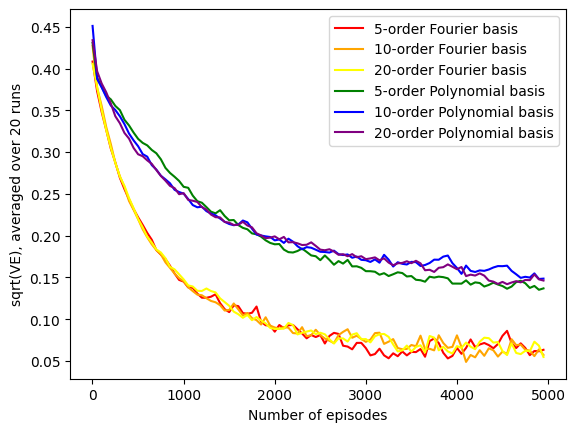

In [ ]:
x = np.arange(1, n_eps+1, plt_step)
plt.plot(x, np.sqrt(y1), color = 'red')
plt.plot(x, np.sqrt(y2), color = 'orange')
plt.plot(x, np.sqrt(y3), color = 'yellow')
plt.plot(x, np.sqrt(y4), color = 'green')
plt.plot(x, np.sqrt(y5), color = 'blue')
plt.plot(x, np.sqrt(y6), color = 'purple')
plt.xlabel("Number of episodes")
plt.ylabel("sqrt(VE), averaged over 20 runs")
plt.legend(["5-order Fourier basis", "10-order Fourier basis", "20-order Fourier basis", "5-order Polynomial basis", "10-order Polynomial basis", "20-order Polynomial basis"])

## Figure 9.10

In [ ]:
n_eps = 10000
plt_step = 10

In [ ]:
value_func = Tiling(200, 50, 4) # 300
alpha = 0.0001 / 50
state_values, y2, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

In [ ]:
value_func = Tiling(100, 50, 2) # 600
alpha = 0.0001 / 50
state_values, y1, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

In [ ]:
value_func = Tiling(400, 50, 8) # n_params = 200
alpha = 0.0001 / 50
state_values, y3, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

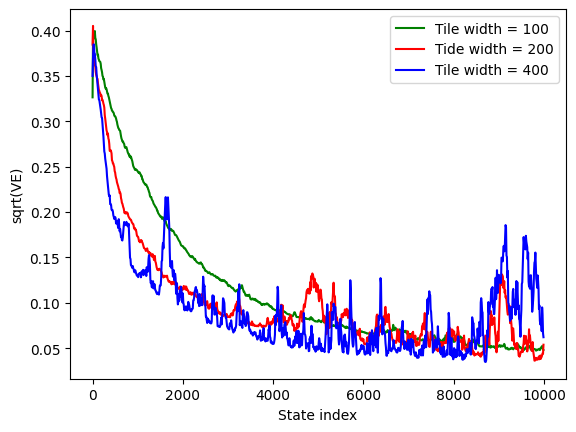

In [ ]:
x = np.arange(1, n_eps+1, plt_step)
plt.plot(x, np.sqrt(y1), color = "green")
plt.plot(x, np.sqrt(y2), color = "red")
plt.plot(x, np.sqrt(y3), color = "blue")
plt.xlabel("State index")
plt.ylabel("sqrt(VE)")
plt.legend(["Tile width = 100", "Tide width = 200", "Tile width = 400"])
plt.show()

In [ ]:
value_func = Tiling(200, 50, 4)    # n_features = 300
alpha = 0.0001 / 50
state_values, y1, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

In [ ]:
value_func = Tiling(200, 20, 10)    # n_features = 120
alpha = 0.0001 / 20
state_values, y2, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

In [ ]:
value_func = Tiling(200, 10, 20)    # n_features = 60
alpha = 0.0001 / 10
state_values, y3, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

In [ ]:
value_func = StateAgregation(10)
alpha = 0.0001
state_values, y4, distribution = gradient_Monte_Carlo(value_func, n_eps, plt_step, alpha, gamma = 1, save_VE = True, true_values = true_values)

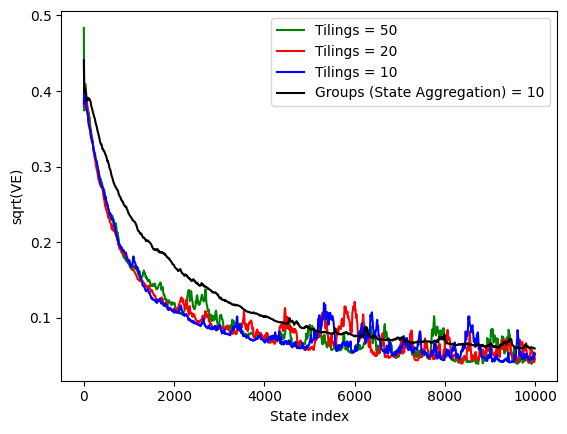

In [ ]:
x = np.arange(1, n_eps+1, plt_step)
plt.plot(x, np.sqrt(y1), color = "green")
plt.plot(x, np.sqrt(y2), color = "red")
plt.plot(x, np.sqrt(y3), color = "blue")
plt.plot(x, np.sqrt(y4), color = "black")
plt.xlabel("State index")
plt.ylabel("sqrt(VE)")
plt.legend(["Tilings = 50", "Tilings = 20", "Tilings = 10", "Groups (State Aggregation) = 10"])
plt.show()